# NARR: Subsetting and OPeNDAP

## About the Dataset

This tutorial uses data from NOAA's [North American Regional Reanalysis](https://www.ncei.noaa.gov/products/weather-climate-models/north-american-regional) (NARR)

> The North American Regional Reanalysis (NARR) is a model produced by the National Centers for Environmental Prediction (NCEP) that generates reanalyzed data for temperature, wind, moisture, soil, and dozens of other parameters. The NARR model assimilates a large amount of observational data from a variety of sources to produce a long-term picture of weather over North America.

For this recipe, we will access the data via [OPeNDAP](https://earthdata.nasa.gov/collaborate/open-data-services-and-software/api/opendap), a widely-used API for remote access of environmental data over HTTP.
A key point is that, since we use using OPeNDAP, _there are no input files to download / cache_. We open the data directly from the remote server.

The data we will use are catalogged here (3D data on pressure levels): <https://psl.noaa.gov/thredds/catalog/Datasets/NARR/pressure/catalog.html>

Let's peek at one file. Xarray should automatically do the right thing with the OPeNDAP url. But just to be safe, we can pass the option, `engine='netcdf4'`, which is needed to open OPeNDAP links correctly. (We will need this again later when writing our recipe.)

In [1]:
import xarray as xr
url = "https://psl.noaa.gov/thredds/dodsC/Datasets/NARR/pressure/air.197901.nc"
ds = xr.open_dataset(url, engine='netcdf4')
ds

/opt/miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


<xarray.Dataset>
Dimensions:            (time: 248, level: 29, y: 277, x: 349)
Coordinates:
  * time               (time) datetime64[ns] 1979-01-01 ... 1979-01-31T21:00:00
  * level              (level) float32 1e+03 975.0 950.0 ... 150.0 125.0 100.0
  * y                  (y) float32 0.0 3.246e+04 ... 8.927e+06 8.96e+06
  * x                  (x) float32 0.0 3.246e+04 ... 1.126e+07 1.13e+07
    lat                (y, x) float32 ...
    lon                (y, x) float32 ...
Data variables:
    Lambert_Conformal  int32 ...
    air                (time, level, y, x) float32 ...
Attributes: (12/17)
    Conventions:                     CF-1.2
    centerlat:                       50.0
    centerlon:                       -107.0
    comments:                        
    institution:                     National Centers for Environmental Predi...
    latcorners:                      [ 1.000001  0.897945 46.3544   46.63433 ]
    ...                              ...
    history:                         created Fri Jan  8 02:35:07 MST 2016 by ...
    dataset_title:                   NCEP North American Regional Reanalysis ...
    references:                      https://www.esrl.noaa.gov/psd/data/gridd...
    source:                          http://www.emc.ncep.noaa.gov/mmb/rreanl/...
    References:                      
    DODS_EXTRA.Unlimited_Dimension:  time

This is just one file.
But it's a very big file (several GB)!
We will want to use the __subsetting__ capability of `XarrayZarrRecipe`. 
To figure out how to subset, let's examine the `_ChunkSizes` attribute.
This attribute part of the NetCDF4 files that the OPeNDAP server is serving.
We want to make sure our subsetting is compatible with the internal chunking of the files.

In [2]:
ds.air._ChunkSizes

array([  1,   1, 277, 349], dtype=int32)

This tells us that we can subset in the `time` or `level` dimensions, but problably should avoid subsetting in the `x` and `y` dimensions.

## Define File Pattern

We are now ready to define the `FilePattern` for the recipe. There is one file per month. So we start with a function like this:

In [3]:
def format_function(time):
    return f"https://psl.noaa.gov/thredds/dodsC/Datasets/NARR/pressure/air.{time}.nc"

To keep things short and simple for this tutorial, we will just use one file, and subset it into many chunks.
But we could easily add more months to build up the entire dataset.
Since each file is monthly, and the number of days per months varies, we cannot set `nitems_per_input` in the `ConcatDim`.

```{note}
It's important that we specify `is_opendap=True` when creating a FilePattern with OPeNDAP URLs.
OPeNDAP is actually an API, so there are no files to download. 
```

In [7]:
from pangeo_forge_recipes.patterns import FilePattern, ConcatDim, MergeDim
time_dim = ConcatDim("time", ["197901"])
pattern = FilePattern(format_function, time_dim, is_opendap=True)
pattern

<FilePattern {'time': 1}>

## Define the Recipe

This tutorial introduces a new option we have not seen before: `subset_inpus={"time": 30}`. This tells the `XarrayZarrRecipe` to break each input file into 30 distinct chunks along the `time` dimension. 

Some other points to consider when defining this recipe.
- Since the inputs are OPeNDAP, we want to use `is_opendap=True`.
- Since we have not specified `nitems_per_input` in the `FilePattern`, we need to explicitly set the target chunks.

In [8]:
from pangeo_forge_recipes.recipes import XarrayZarrRecipe
recipe = XarrayZarrRecipe(
    pattern, 
    subset_inputs={"time": 30},
    target_chunks={"time": 1},
)
recipe

XarrayZarrRecipe(file_pattern=<FilePattern {'time': 1}>, inputs_per_chunk=1, target_chunks={'time': 1}, target=None, input_cache=None, metadata_cache=None, cache_inputs=False, copy_input_to_local_file=False, consolidate_zarr=True, consolidate_dimension_coordinates=True, xarray_open_kwargs={'engine': 'netcdf4'}, xarray_concat_kwargs={}, delete_input_encoding=True, process_input=None, process_chunk=None, lock_timeout=None, subset_inputs={'time': 30}, open_input_with_fsspec_reference=False)

## Assign Targets

Since we cannot cache the OPeNDAP inputs, we don't need an input cache target.

In [9]:
import tempfile
from fsspec.implementations.local import LocalFileSystem
from pangeo_forge_recipes.storage import FSSpecTarget, CacheFSSpecTarget, MetadataTarget

fs_local = LocalFileSystem()

target_dir = tempfile.TemporaryDirectory()
target = FSSpecTarget(fs_local, target_dir.name)

meta_dir = tempfile.TemporaryDirectory()
meta_store = MetadataTarget(fs_local, meta_dir.name)

recipe.target = target
recipe.metadata_cache = meta_store
recipe

XarrayZarrRecipe(file_pattern=<FilePattern {'time': 1}>, inputs_per_chunk=1, target_chunks={'time': 1}, target=FSSpecTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x17d897670>, root_path='/var/folders/n8/63q49ms55wxcj_gfbtykwp5r0000gn/T/tmpeoje0wk0'), input_cache=None, metadata_cache=MetadataTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x17d897670>, root_path='/var/folders/n8/63q49ms55wxcj_gfbtykwp5r0000gn/T/tmppjq2c3ik'), cache_inputs=False, copy_input_to_local_file=False, consolidate_zarr=True, consolidate_dimension_coordinates=True, xarray_open_kwargs={'engine': 'netcdf4'}, xarray_concat_kwargs={}, delete_input_encoding=True, process_input=None, process_chunk=None, lock_timeout=None, subset_inputs={'time': 30}, open_input_with_fsspec_reference=False)

### Run the Recipe

In [10]:
# logging will display some interesting information about our recipe during execution
import logging
import sys

logging.basicConfig(
    format='%(asctime)s [%(levelname)s] %(name)s - %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
    stream=sys.stdout,
)
logger = logging.getLogger("pangeo_forge_recipes")
logger.setLevel(logging.INFO)

Here we just use the simple python function executor.

In [ ]:
recipe.to_function()()

2021-11-13 22:48:19 [INFO] pangeo_forge_recipes.recipes.xarray_zarr - Caching metadata for input 'time-0'
2021-11-13 22:48:19 [INFO] pangeo_forge_recipes.recipes.xarray_zarr - Opening input with Xarray time-0: 'https://psl.noaa.gov/thredds/dodsC/Datasets/NARR/pressure/air.197901.nc'
2021-11-13 22:48:19 [INFO] pangeo_forge_recipes.recipes.xarray_zarr - Creating a new dataset in target
2021-11-13 22:48:19 [INFO] pangeo_forge_recipes.recipes.xarray_zarr - Opening inputs for chunk time-0,time-0
2021-11-13 22:48:19 [INFO] pangeo_forge_recipes.recipes.xarray_zarr - Opening input with Xarray time-0: 'https://psl.noaa.gov/thredds/dodsC/Datasets/NARR/pressure/air.197901.nc'


/opt/miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py:116: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  return xr.open_zarr(target.get_mapper())


2021-11-13 22:48:19 [INFO] pangeo_forge_recipes.recipes.xarray_zarr - Subsetting input according to time-0
2021-11-13 22:48:19 [INFO] pangeo_forge_recipes.recipes.xarray_zarr - Combining inputs for chunk 'time-0,time-0'


/opt/miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-11-13 22:48:19 [INFO] pangeo_forge_recipes.recipes.xarray_zarr - Storing dataset in /var/folders/n8/63q49ms55wxcj_gfbtykwp5r0000gn/T/tmpeoje0wk0
2021-11-13 22:48:19 [INFO] pangeo_forge_recipes.recipes.xarray_zarr - Expanding target concat dim 'time' to size 248
2021-11-13 22:48:19 [INFO] pangeo_forge_recipes.recipes.xarray_zarr - Opening inputs for chunk time-0,time-0
2021-11-13 22:48:19 [INFO] pangeo_forge_recipes.recipes.xarray_zarr - Opening input with Xarray time-0: 'https://psl.noaa.gov/thredds/dodsC/Datasets/NARR/pressure/air.197901.nc'
2021-11-13 22:48:20 [INFO] pangeo_forge_recipes.recipes.xarray_zarr - Subsetting input according to time-0
2021-11-13 22:48:20 [INFO] pangeo_forge_recipes.recipes.xarray_zarr - Combining inputs for chunk 'time-0,time-0'
2021-11-13 22:48:20 [INFO] pangeo_forge_recipes.recipes.xarray_zarr - Storing variable time chunk time-0,time-0 to Zarr region (slice(0, 8, None),)


/opt/miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2021-11-13 22:48:28 [INFO] pangeo_forge_recipes.recipes.xarray_zarr - Storing variable air chunk time-0,time-0 to Zarr region (slice(0, 8, None), slice(None, None, None), slice(None, None, None), slice(None, None, None))
2021-11-13 22:48:28 [INFO] pangeo_forge_recipes.recipes.xarray_zarr - Opening inputs for chunk time-0,time-1
2021-11-13 22:48:28 [INFO] pangeo_forge_recipes.recipes.xarray_zarr - Opening input with Xarray time-0: 'https://psl.noaa.gov/thredds/dodsC/Datasets/NARR/pressure/air.197901.nc'
2021-11-13 22:48:28 [INFO] pangeo_forge_recipes.recipes.xarray_zarr - Subsetting input according to time-1
2021-11-13 22:48:28 [INFO] pangeo_forge_recipes.recipes.xarray_zarr - Combining inputs for chunk 'time-0,time-1'
2021-11-13 22:48:28 [INFO] pangeo_forge_recipes.recipes.xarray_zarr - Storing variable time chunk time-0,time-1 to Zarr region (slice(8, 16, None),)


## Check The Outputs

In [9]:
ds_target =  xr.open_zarr(target.get_mapper())
ds_target

<xarray.Dataset>
Dimensions:            (level: 29, time: 248, x: 349, y: 277)
Coordinates:
    lat                (y, x) float32 dask.array<chunksize=(277, 349), meta=np.ndarray>
  * level              (level) float32 1e+03 975.0 950.0 ... 150.0 125.0 100.0
    lon                (y, x) float32 dask.array<chunksize=(277, 349), meta=np.ndarray>
  * time               (time) datetime64[ns] 1979-01-01 ... 1979-01-31T21:00:00
  * x                  (x) float32 0.0 3.246e+04 ... 1.126e+07 1.13e+07
  * y                  (y) float32 0.0 3.246e+04 ... 8.927e+06 8.96e+06
Data variables:
    Lambert_Conformal  int32 ...
    air                (time, level, y, x) float32 dask.array<chunksize=(1, 29, 277, 349), meta=np.ndarray>
Attributes: (12/17)
    Conventions:                     CF-1.2
    DODS_EXTRA.Unlimited_Dimension:  time
    References:                      
    centerlat:                       50.0
    centerlon:                       -107.0
    comments:                        
    ...                              ...
    platform:                        Model
    references:                      https://www.esrl.noaa.gov/psd/data/gridd...
    source:                          http://www.emc.ncep.noaa.gov/mmb/rreanl/...
    standardpar1:                    50.0
    standardpar2:                    50.000001
    title:                           8x Daily NARR

/opt/miniconda3/envs/pangeo-forge/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


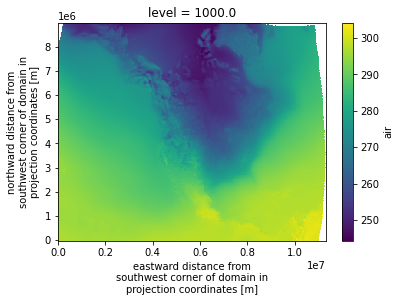

In [11]:
ds_target.air.isel(level=0).mean("time").plot()